Duffing
x'' -gamma*cos(omega*t) + kx + bx^2 + delta x'

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
import time

delta = 0.2
gamma = 0.4
omega = 1.1
k = 1.0
b = 1.0
m = 1.0
X_max = 1.0

# # # jesli test:
# gamma = 0.0
# omega = 0.0
# b = 0.0


T = np.pi*2/omega
#  GDYTEST !!! : T = 2*np.pi/np.sqrt(k/m) # bo nie ma wtedy omega
T = np.pi*2/omega
t_end = T*4 #parametry czasu
t_start = 0
n_dt = 1000 #dzielimy cały czas na n_dt dannych
dt = (t_end - t_start) / n_dt

window_size =  20 #ile widzi rnn
n_data = 500 #bedzie 500*200 = 100k
batch_size = 64

def oscillator_duff(t,y):
  x, v = y
  dxdt = v
  dvdt = (-k/m)*x - delta*v -b*x**3 + gamma*np.cos(omega*t)

  return [dxdt,dvdt]

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
def data_linear_duff(n_data, x0, v0, dt=dt): #dajemy ile chcemy danych i x0 v0
  t_end = n_data*dt
  t_eval = np.linspace(t_start, n_data*dt, n_data)
  sol = solve_ivp(oscillator_duff, [t_start, t_end], [x0, v0], t_eval= t_eval,
                  method='RK45', rtol=1e-9, atol=1e-9)
  x = sol.y[0]
  v = sol.y[1]

  return x,v

x,v = data_linear_duff(100,x0= X_max, v0=0.0)
print(np.shape(x))


(100,)


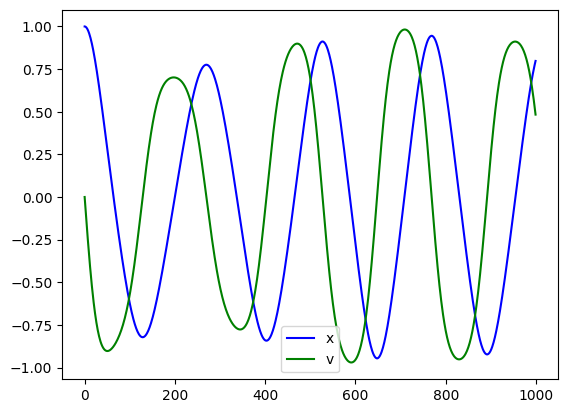

(1000,)


In [4]:
t_s = 0
X_max = 1
M= 1000
t = np.linspace(t_s, M*dt, M)


x, v= data_linear_duff(M, x0 =X_max, v0=0.0)
plt.plot(x, color = 'blue', label = 'x')
plt.plot(v, color = 'green', label = 'v')
plt.legend()
plt.show()
print(np.shape(x))

In [57]:
def loader_linear_duff(n_out = window_size-1):
  data = [] #(batch_size, 2) bo [x0,v0]
  y_true = [] #(batch_size, 2)

  #E = 0.5*mv^2 + 0.5*kx^2 = const = 0.5*k*X_max^2
  n_data_lin = 10000
  x_random = np.random.uniform(-X_max,X_max, n_data_lin) #(n_data)

  E_total = 0.5*k*X_max**2 + 0.25*b*X_max**4
  t_start = 0

  for x_initial in x_random:

    E_available = E_total - 0.5*k*x_initial**2 - 0.25*b*x_initial**4
    if E_available > 0:
        v_max = np.sqrt(2 * E_available / m)
        v_initial = np.random.uniform(-v_max, v_max)
    else:
        v_initial = 0.0

    x_data, v_data = data_linear_duff(n_dt, x_initial, v_initial)
    data.append([x_initial, v_initial, t_start])

    x_append = x_data[1:window_size+1] #data_linear_duff zwraca teraz inirial
    v_append = v_data[1:window_size+1]

    y_true.append([x_append, v_append])

  data = np.array(data)
  y_true = np.transpose(np.array(y_true), (0,2,1))
  data = torch.tensor(data, dtype = torch.float32)
  y_true = torch.tensor(y_true, dtype = torch.float32)

  dataset = TensorDataset(data, y_true)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  print(f"Shape of data: {data.shape}")
  print(f"Shape of targets: {y_true.shape}")

  return dataset, loader
print(f"Ilośc dt w t_end: {n_dt}")
print(f"Window {window_size}")

dataset, loader = loader_linear_duff()

Ilośc dt w t_end: 1000
Window 20
Shape of data: torch.Size([10000, 3])
Shape of targets: torch.Size([10000, 20, 2])


In [59]:
torch.save({
    'data': dataset,  # tensor z wejściami
    'loader': loader  # tensor z wyjściami
}, 'data_duff\duffing_dataset.pt')

check = torch.load('data_duff\duffing_dataset.pt')
dataset = check['data']
loader = check['loader']

C:\Users\qmiko\AppData\Local\Temp\ipykernel_21384\2084490130.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load('data_duff\duffing_dataset.pt')


In [60]:
def loss_physics(pred, target, dt):
  x = pred[:,0] #(batch, 2)
  v = pred[:,1] #(batch, 2)

  dx = x[:, 1:] - x[:, :-1]
  v_pred = dx/dt

  loss_1 = torch.mean((v_pred - v[:, 1:])**2) # z tego że dx/dt = v


  dv = v[:, 1:] - v[:, :-1]
  a_pred = dv/dt
  t = [2*dt, 3*dt]
  t = torch.tensor(t, device=DEVICE, dtype=torch.float32)

  Res = m*a_pred + k*x[:,1:] + delta*v[:,1:] + b*x[:,1:]**3 - gamma*torch.cos(omega*t)

  loss_2 = torch.mean(Res**2)
  w_kinematic = 1.0
  w_dynamic = 1.0
  loss = loss_1*w_kinematic + loss_2*w_dynamic
  return loss


In [61]:
def training(linear, loader, loader_val, dt, t_start, t_end):

  epochs = 50
  eta = 0.001

  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(linear.parameters(), lr = eta)
  plateu = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.2, patience = 3, threshold=0.001,threshold_mode = 'rel', cooldown=3)


  #phys_weight zaczyna od małej wartosci rzędu 1 aż do około 1500 przy epoce 10
  phys_weight = np.concatenate((np.linspace(1, 1000, 20), [1000]*30))
  previous_eta = eta
  loss_history = []


  for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")
    current_lr = optimizer.param_groups[0]['lr']

    if current_lr < previous_eta:
      previous_eta = current_lr
      print("Plateu!")
    print(f"Eta: {current_lr}")

    epoch_loss = 0.0
    val_loss = 0.0

    linear.train()
    for batch in loader:
      sample, target = batch
      sample = sample.to(DEVICE)
      target = target.to(DEVICE)
      pred = linear(sample)

      l1 = loss(pred, target)
      l2 = loss_physics(pred, target, dt)
      l = (l1 + l2)

      l.backward()
      epoch_loss += l.detach()
      optimizer.step()
      optimizer.zero_grad()

    linear.eval()
    for batch_val in loader_val:
      sample, target = batch_val
      sample = sample.to(DEVICE)
      target = target.to(DEVICE)
      pred = linear(sample)

      l1 = loss(pred, target)
      l2 = loss_physics(pred, target, dt)
      val_loss += (l1+l2).item()

    val_loss = val_loss/len(loader_val)
    epoch_loss = epoch_loss/len(loader)
    plateu.step(val_loss)

    print(f"Total loss: {epoch_loss}\nValidation loss: {val_loss}\n")
    loss_history.append(val_loss)

  return linear, loss_history

In [62]:
class Linear(nn.Module):
  def __init__(self, input_size = 2, output_size = (window_size,2), num_neurons = 50):
    super().__init__()

    self.input_size = 3
    self.output_size = output_size
    self.num_neurons = num_neurons
    self.l1 = nn.Linear(self.input_size, self.num_neurons)
    self.l2 = nn.Linear(self.num_neurons, self.num_neurons)
    self.l3 = nn.Linear(self.num_neurons, self.num_neurons//2)
    self.l4 = nn.Linear(self.num_neurons//2, output_size[0]*2)

  def forward(self, sample):
    x = F.tanh(self.l1(sample))

    x = F.tanh(self.l2(x))

    x = F.tanh(self.l3(x))
    x = self.l4(x)
    x = x.view(-1, self.output_size[0], 2) #bedzie (batch, ktore delta t, [x,v])

    return x

  def param(self):
    total_param = sum(p.numel() for p in self.parameters())
    print("Total parameters:", total_param)


In [63]:
check = torch.load('data_duff\duffing_dataset.pt')
check_val = torch.load('data_duff\duffing_dataset_val.pt')
loader = check['loader']
loader_val = check['loader']

linear = Linear()
linear = linear.to(DEVICE)
linear, history = linear, history = training(
    linear,
    loader,
    loader_val,
    dt,
    t_start,
    t_end
)




C:\Users\qmiko\AppData\Local\Temp\ipykernel_21384\687080198.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load('data_duff\duffing_dataset.pt')
C:\Users\q

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
Eta: 0.001
Total loss: 3.401482343673706
Validation loss: 0.29508539891926344

Epoch 2/50
Eta: 0.001
Total loss: 0.20573143661022186
Validation loss: 0.12790737946511835

Epoch 3/50
Eta: 0.001
Total loss: 0.08643654733896255
Validation loss: 0.06069042647530319

Epoch 4/50
Eta: 0.001
Total loss: 0.050529301166534424
Validation loss: 0.044264846712730496

Epoch 5/50
Eta: 0.001
Total loss: 0.0415177121758461
Validation loss: 0.03944680004552671

Epoch 6/50
Eta: 0.001
Total loss: 0.038477592170238495
Validation loss: 0.038059067253948774

Epoch 7/50
Eta: 0.001
Total loss: 0.037364356219768524
Validation loss: 0.037188149870011455

Epoch 8/50
Eta: 0.001
Total loss: 0.036761727184057236
Validation loss: 0.036510920923226955

Epoch 9/50
Eta: 0.001
Total loss: 0.036312978714704514
Validation loss: 0.03613350075331463

Epoch 10/50
Eta: 0.001
Total loss: 0.03596808388829231
Validation loss: 0.035946539288778216

Epoch 11/50
Eta: 0.001
Total loss: 0.03577669709920883
Validation loss: 

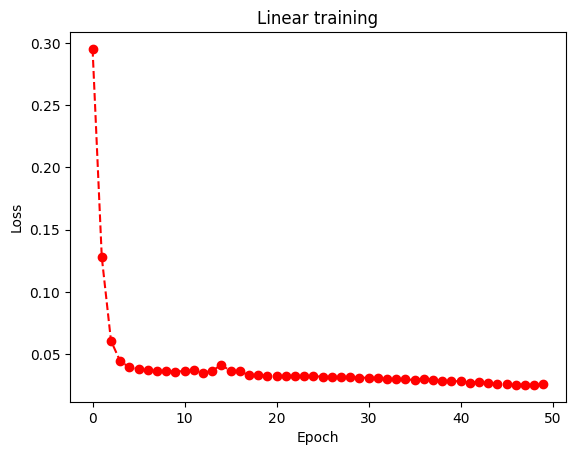

In [67]:
plt.plot(history, 'ro--')
plt.title("Linear training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("plots/linear_training.png")

In [68]:
torch.save(linear.state_dict(), "duffing_models\linear")

In [69]:
def data_rnn_duff(n_data, t0, x0, v0, dt=dt):
  t_start = t0
  t_end = t0 + n_data * dt
  t_eval = np.linspace(t0, t_end, n_data)

  sol = solve_ivp(oscillator_duff, [t_start, t_end], [x0, v0],
                  t_eval= t_eval,method='RK45', rtol=1e-9, atol=1e-9)
  x = sol.y[0]
  v = sol.y[1]

  combined_data = np.stack((x, v, t_eval), axis=1)
  data = []

  for idx in range(n_data - window_size+1):
    data.append(combined_data[idx: idx+window_size])

  return np.array(data)

data = data_rnn_duff(n_dt, 0.0, X_max, 0.0)
x = data[:, :, 0]
v = data[:, :, 1]
t = data[:, :, 2]

print(f"dt to procent okresu {dt/T*100}")
print(f"dt : {dt}")
print(np.shape(x), np.shape(v))

dt to procent okresu 0.4
dt : 0.02284794657156213
(981, 20) (981, 20)


In [70]:
def loader_rnn_duff(n_data, batch_size = 64):

    input_data_list = []  # (batch_size, 2) bo [x0, v0]
    target_data_list = [] # (batch_size, 2)

    x_random = np.random.uniform(-1, 1, n_data)
    x0 = x_random * X_max

    E_total = 0.5 * k * X_max**2 + 0.25 * b * X_max**4

    for x_initial in x0:

        E_available = E_total - 0.5*k*x_initial**2 - 0.25*b*x_initial**4
        if E_available > 0:
            v_max = np.sqrt(2 * E_available / m)
            v_initial = np.random.uniform(-v_max, v_max)
        else:
            v_initial = 0.0

        window = data_rnn_duff(n_dt, t_start, x_initial, v_initial) #zwraca (994, window_size, 3)

        input_data_list.append(window[:-1])

        target_data_list.append(window[1:, -1, :2])

    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    data = torch.tensor(input_data, dtype=torch.float32) #(-, window, 3)
    target_tensor = torch.tensor(target_data, dtype=torch.float32)

    x_mean = data[:, :, 0].mean()
    v_mean = data[:, :, 1].mean()
    t_max = data[:,:,2].max()

    x_std = data[:,:,0].std()
    v_std = data[:,:,1].std()

    x_data = (data[:,:, 0]-x_mean)/x_std
    v_data = (data[:,:, 1]-v_mean)/v_std
    t_data = data[:,:,2]/t_max

    data = torch.stack((x_data, v_data, t_data), dim = 2)


    dataset = TensorDataset(data, target_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Shape of data: {input_data.shape}")
    print(f"Shape of targets: {target_data.shape}")

    return dataset, loader


In [71]:
def loader_rnn_duff_noNorm(n_data, batch_size = 64):

    input_data_list = []  # (batch_size, 2) bo [x0, v0]
    target_data_list = [] # (batch_size, 2)

    x_random = np.random.uniform(-1, 1, n_data)
    x0 = x_random * X_max

    E_total = 0.5 * k * X_max**2 + 0.25 * b * X_max**4

    for x_initial in x0:

        E_available = E_total - 0.5*k*x_initial**2 - 0.25*b*x_initial**4
        if E_available > 0:
            v_max = np.sqrt(2 * E_available / m)
            v_initial = np.random.uniform(-v_max, v_max)
        else:
            v_initial = 0.0

        window = data_rnn_duff(n_dt, t_start, x_initial, v_initial) #zwraca (994, window_size, 3)

        input_data_list.append(window[:-1])

        target_data_list.append(window[1:, -1, :2])

    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    data = torch.tensor(input_data, dtype=torch.float32) #(-, window, 3)
    target_tensor = torch.tensor(target_data, dtype=torch.float32)

    dataset = TensorDataset(data, target_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Shape of data: {input_data.shape}")
    print(f"Shape of targets: {target_data.shape}")

    return dataset, loader


In [72]:
def checkpoint(path, model, scheduler, optimizer, epoch, loss):
  checkpoint = {
      "model_state_dict" : model.state_dict(),
      "scheduler_state_dict" : scheduler.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
      "epoch" : epoch,
      "loss": loss
  }

  torch.save(checkpoint, path)
  print("Saved to given directory!")

def load(path, model, optimizer = None, scheduler = None, device = "cuda"):
  checkpoint = torch.load(path, map_location=device)

  model.to(device)
  model.load_state_dict(checkpoint["model_state_dict"])

  if optimizer is not None:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  if scheduler is not None:
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
  epoch = checkpoint["epoch"]

  print("Loaded correctly!")
  return model, optimizer, scheduler, epoch


In [73]:
class RNN_duff(nn.Module):
  def __init__(self, input_size = 3,  hidden_size = 64, num_layers_lstm = 2, output_size =2):
    super().__init__()
    self.input_size = input_size #bo 2 od sample 4 od h i 4 od c
    self.hidden_size = hidden_size
    self.num_layers_lstm = num_layers_lstm
    self.output_size = output_size

    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers_lstm, batch_first=True) #zwraca (batch, 4, 2)

    self.fc = nn.Sequential(
            nn.Linear(hidden_size, 120),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(120, 80),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(80, 64),
            nn.Tanh(),
            nn.Linear(64, output_size)
        )

  def forward(self, sample): #sample (batch, seq=4, feat =2)
    x, _ = self.lstm(sample) #nie chce zapisaywac poprzednich batchy bo bede robil shuffle, (num_leyers, bacth, hiddenisze)
    x = x[:, -1, :] # x jest (batch, seq, hidden_size)
    x = self.fc(x)
    return x

  def param(self):
    total_param = sum(p.numel() for p in self.parameters())
    print("Total parameters:", total_param)

  def save_best(self,epoch, optimizer, scheduler=None, phys_weight_idx=None):
    path = "/Models/Best_model"
    checkpoint(path= path, model =self, scheduler=None, epoch=epoch, optimizer=optimizer, phys_weight_idx=None )




In [74]:
dataset, loader = loader_rnn_duff_noNorm(100) #de facto ile sciezek widzi, kazda sciezka to 1000-window_size dancyh
val_dataset, val_loader = loader_rnn_duff_noNorm(10)
test_dataset, test_loader = loader_rnn_duff_noNorm(10) #nie wiem czy uzywane bedzie

num_samples = len(loader.dataset)

Shape of data: (98000, 20, 3)
Shape of targets: (98000, 2)
Shape of data: (9800, 20, 3)
Shape of targets: (9800, 2)
Shape of data: (9800, 20, 3)
Shape of targets: (9800, 2)


In [75]:
rnn = RNN_duff()
rnn.train()

RNN_duff(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=120, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=120, out_features=80, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=80, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [76]:
def loss_physics_rnn(pred, target, dt, sample):
  x = pred[:,0]
  v = pred[:,1]

  x_prev = sample[:, -1, 0]
  v_prev = sample[:, -1, 1]
  t_prev = sample[:, -1, 2]

  #sample to (batch, seq, 3)

  dx = x - x_prev
  v_pred = dx/dt

  v_true = target[:, 1]
  loss_1 = torch.mean((v_pred - v_true)**2) # z tego że dx/dt = v
  dv = v - v_prev

  a_pred = dv/dt

  t = t_prev + dt
  Res = m*a_pred + k*x + delta*v + b*x**3 - gamma*torch.cos(omega*t)

  loss_2 = torch.mean(Res**2)
  w_kinematic = 1.0
  w_dynamic = 1.0
  loss = loss_1*w_kinematic + loss_2*w_dynamic
  return loss


In [77]:
def training_rnn_duff(rnn, loader, loader_val, epochs = 15,max_time= 100000000, save_best = True, stop_on_plateu = 10):
    eta = 0.001

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=eta)
    plateu = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.001, threshold_mode='rel', cooldown=3)

    # Wagi fizyki
    if epochs <= 20:
      w_phys = np.exp(np.arange(0, 20)*0.4) # Dopasowane do 20 epok
    else:
      w_phys = np.concatenate([np.exp(np.arange(0, 20)*0.4), [np.exp(19*0.4)]*(epochs-20)])
    w_phys = torch.tensor(w_phys, dtype=torch.float32, device=DEVICE, requires_grad=False)

    previous_eta = eta
    loss_history = []
    mse_history = [] #do stop_on_plateu bo cały los bedzie sie zmienial przez wage fizyczna, jedynie staly bedzie mse
    low_mse = np.inf
    t0 = time.perf_counter()

    for epoch in tqdm(range(epochs)):
      print("\n\n")

      t = time.perf_counter() - t0
      if t >= max_time:
        print("Too much time")
        return rnn, loss_history

      current_lr = optimizer.param_groups[0]['lr']


      if current_lr < previous_eta:
          previous_eta = current_lr
          print("Plateu!")
          print(f"Eta: {current_lr}")

      epoch_loss = 0.0
      val_loss = 0.0
      mse_loss = 0.0

      # --- TRENING ---
      rnn.train()
      for batch in loader:
          sample, target = batch
          sample = sample.to(DEVICE)
          target = target.to(DEVICE)
          optimizer.zero_grad() # Zerowanie na początku

          pred = rnn(sample)

          l1 = loss_fn(pred, target)
          l2 = loss_physics_rnn(pred, target, dt, sample)

          l = l1 + (w_phys[epoch] * l2)

          l.backward()
          epoch_loss += l.item() # Zbieramy .item()

          torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1.0)
          optimizer.step()

      # --- WALIDACJA ---
      rnn.eval()
      with torch.no_grad():
          for batch_val in loader_val:
              sample, target = batch_val
              sample = sample.to(DEVICE)
              target = target.to(DEVICE)
              pred = rnn(sample)

              l1 = loss_fn(pred, target)
              l2 = loss_physics_rnn(pred, target, dt, sample)

              l = l1 + (w_phys[epoch] * l2)
              val_loss += l.item()
              mse_loss += l1.item()

      epoch_loss /= len(loader)
      val_loss /= len(loader_val)
      mse_loss /= len(loader_val)

      plateu.step(mse_loss)
      real_loss = val_loss/w_phys[epoch].cpu().numpy()
      real_loss = real_loss.item()

      print(f"Epoch {epoch+1}/{epochs} | Phys Weight: {w_phys[epoch]:.3f}")
      print(f"Training loss: {epoch_loss:.4f} | Validation loss: {val_loss:.4f} | Real_val_loss = {real_loss:.5f} | MSE loss: {mse_loss:.10f}" )

      loss_history.append(val_loss)
      mse_history.append(mse_loss)

      #STOP ON PLATEU
      if stop_on_plateu != 0 and epoch >= stop_on_plateu: #wczesniej sie uczy zawsze
        min_index = np.argmin(mse_history)
        if min_index+1 < len(mse_history) - stop_on_plateu:
          print("Stop on Plateu!")
          real_val_loss = loss_history/w_phys.cpu().numpy()[:len(loss_history)]
          return rnn, loss_history, real_val_loss

      #SAVE BEST
      if save_best and epoch >= 5: #nie zapisujemy od poczatku
        if mse_history[-1] < low_mse:
          low_mse = mse_history[-1]
          print("Checkpoint!")
          checkpoint(path=r"duffing_models\rnn", model=rnn, epoch=epoch+1,
                     optimizer=optimizer, loss = low_mse, scheduler = plateu )


    real_val_loss = loss_history/ w_phys.cpu().numpy()
    return rnn, loss_history, real_val_loss

In [78]:
rnn = RNN_duff().to(DEVICE)
print(f"Ilość batchy: {len(loader)}")
print(f"Ilość próbek: {len(dataset)}")
rnn.param()

print("\nRozpoczynam trening:\n")
rnn, loss, real_loss = training_rnn_duff(rnn, loader, val_loader, epochs= 100) #skalujemy caly czas loss wiec real loss to phys*loss

Ilość batchy: 1532
Ilość próbek: 98000
Total parameters: 73738

Rozpoczynam trening:



  0%|          | 0/100 [00:00<?, ?it/s]




Epoch 1/100 | Phys Weight: 1.000
Training loss: 47.8131 | Validation loss: 2.9341 | Real_val_loss = 2.93405 | MSE loss: 0.0007720081



Epoch 2/100 | Phys Weight: 1.492
Training loss: 10.2672 | Validation loss: 2.6757 | Real_val_loss = 1.79356 | MSE loss: 0.0004578952



Epoch 3/100 | Phys Weight: 2.226
Training loss: 10.3062 | Validation loss: 12.8237 | Real_val_loss = 5.76204 | MSE loss: 0.0014239743



Epoch 4/100 | Phys Weight: 3.320
Training loss: 13.2882 | Validation loss: 6.2525 | Real_val_loss = 1.88322 | MSE loss: 0.0004855503



Epoch 5/100 | Phys Weight: 4.953
Training loss: 17.5873 | Validation loss: 8.1920 | Real_val_loss = 1.65394 | MSE loss: 0.0004452046



Epoch 6/100 | Phys Weight: 7.389
Training loss: 23.1756 | Validation loss: 8.1300 | Real_val_loss = 1.10027 | MSE loss: 0.0002874412
Checkpoint!
Saved to given directory!



Epoch 7/100 | Phys Weight: 11.023
Training loss: 32.0576 | Validation loss: 10.3077 | Real_val_loss = 0.93509 | MSE loss: 0.0002475399
Checkpo

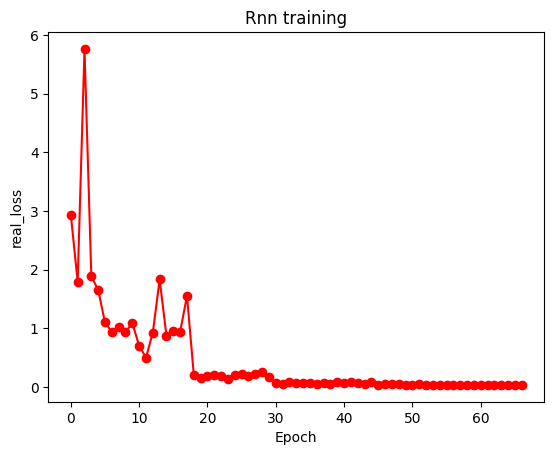

In [80]:
plt.plot(real_loss, 'ro-')
plt.title("Rnn training")
plt.xlabel("Epoch")
plt.ylabel("real_loss")
plt.savefig("plots/rnn_training")

In [81]:
def load_models():
    linear = Linear()
    rnn = RNN_duff()
    check = (torch.load("duffing_models/rnn", weights_only=True))
    rnn.load_state_dict(check['model_state_dict'])
    
    linear.load_state_dict(torch.load("duffing_models/linear", weights_only=True))
    rnn.eval()
    linear.eval()
    
    rnn = rnn.to(DEVICE)
    linear = linear.to(DEVICE)
    
    return linear, rnn
linear, rnn = load_models()

Start symulacji hybrydowej (Solver -> RNN)...
dt: 0.02285
1. Solver: Generuje rozbieg (20 kroków)
2. RNN:    Symuluje pozostałe 980 kroków


RNN Predicting:   0%|          | 0/980 [00:00<?, ?it/s]

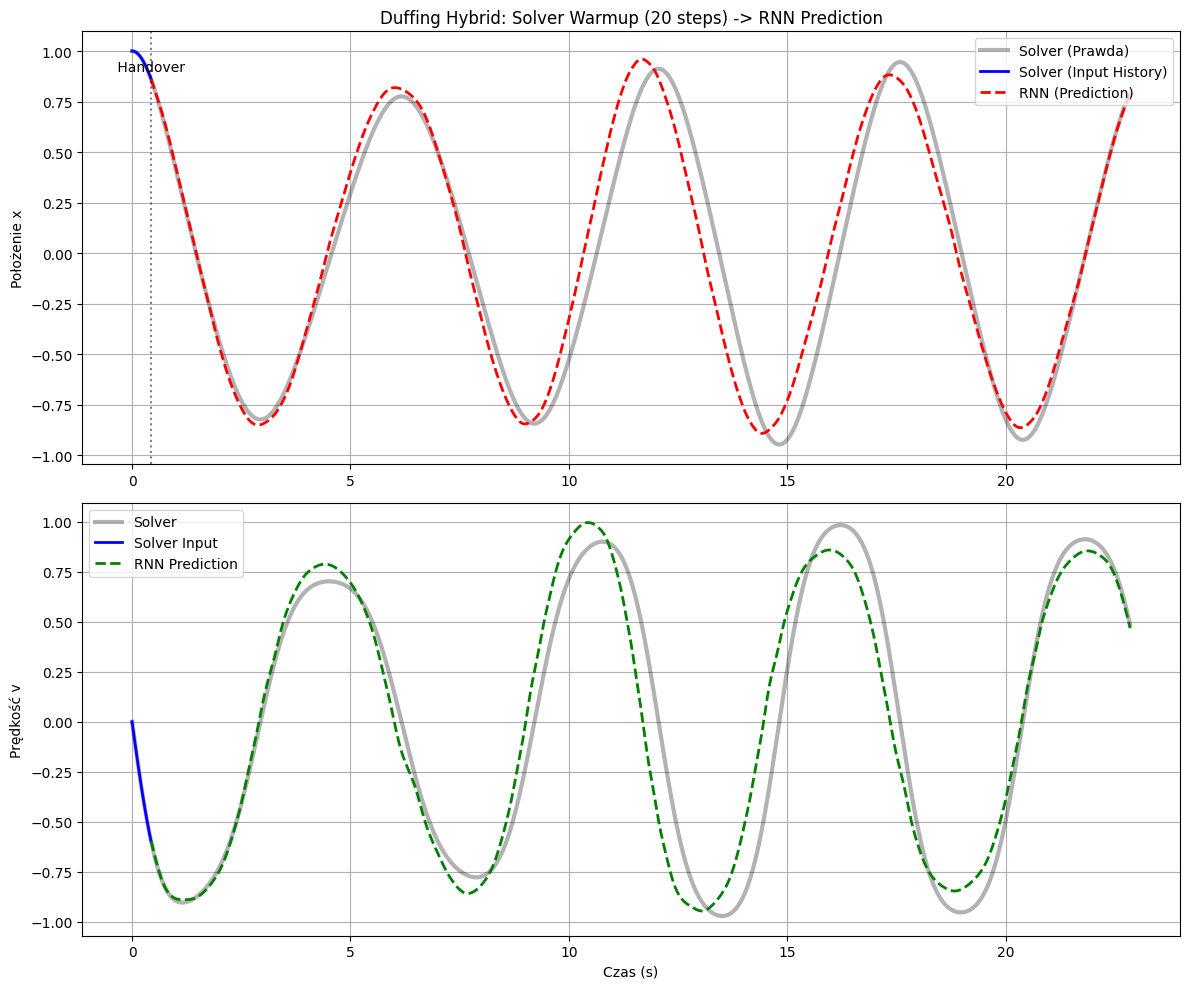


Błąd MSE (tylko część RNN):
MSE x: 0.021002
MSE v: 0.032482


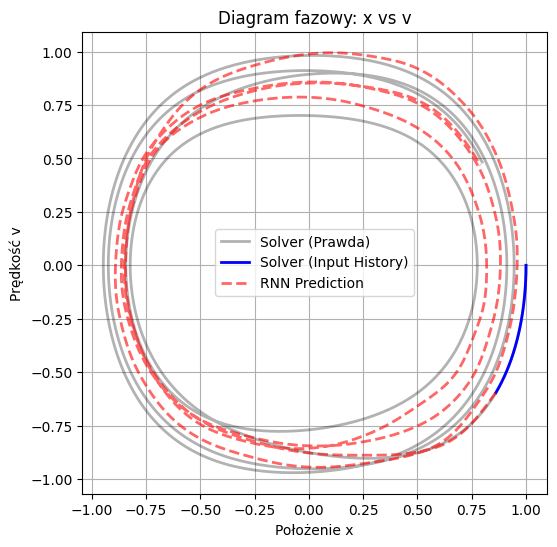

In [94]:
def evaluate_solver_rnn_hybrid(rnn_model, x0, v0, window_size, t_start, t_end, n_dt):
    """
    1. Solver (Ground Truth): Generuje pierwsze 'window_size' kroków (rozbieg).
    2. RNN Model: Przejmuje pałeczkę i symuluje resztę do t_end.
    """
    rnn_model.eval()

    # --- USTAWIENIA CZASU ---
    # Muszą być identyczne jak przy generowaniu danych treningowych!
    dt = (t_end - t_start) / n_dt
    t_eval = np.linspace(t_start, t_end, n_dt)

    print(f"Start symulacji hybrydowej (Solver -> RNN)...")
    print(f"dt: {dt:.5f}")
    print(f"1. Solver: Generuje rozbieg ({window_size} kroków)")
    print(f"2. RNN:    Symuluje pozostałe {len(t_eval) - window_size} kroków")

    # --- ETAP 0: GROUND TRUTH (SOLVER - Całość) ---
    # Rozwiązujemy całość, żeby mieć odniesienie (szara linia na wykresie)
    sol = solve_ivp(oscillator_duff, [t_start, t_end], [x0, v0], t_eval=t_eval, method='RK45', rtol=1e-9, atol=1e-9)
    true_x = sol.y[0]
    true_v = sol.y[1]

    # --- ETAP 1: ROZBIEG (Inicjalizacja z Solvera) ---
    # Bierzemy idealne dane z solvera jako historię dla RNN
    # Format danych to [x, v, t]

    x_hist = true_x[:window_size]
    v_hist = true_v[:window_size]
    t_hist = t_eval[:window_size]

    # Budujemy tensor startowy (1, window_size, 3)
    # Kolejność cech musi być taka sama jak w loaderze: [x, v, t]
    initial_seq_np = np.stack([x_hist, v_hist, t_hist], axis=1)
    current_seq = torch.tensor(initial_seq_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    # Listy z wynikami - zaczynamy od historii z solvera
    pred_x = list(x_hist)
    pred_v = list(v_hist)

    # --- ETAP 2: PĘTLA AUTOREGRESJI RNN ---
    with torch.no_grad():
        # Startujemy od momentu, gdzie kończy się okno
        for i in tqdm(range(window_size, len(t_eval)), desc="RNN Predicting"):

            # 1. Predykcja RNN (zwraca x, v)
            out = rnn_model(current_seq) # (1, 2)

            next_x = out[0, 0].item()
            next_v = out[0, 1].item()

            # Pobieramy czas dla następnego kroku z t_eval (bo czas jest znany deterministycznie)
            next_t = t_eval[i]

            # 2. Zapisujemy wynik
            pred_x.append(next_x)
            pred_v.append(next_v)

            # 3. Aktualizacja okna (przesuwamy w lewo, dodajemy nowy punkt na koniec)
            # Nowy punkt musi mieć format [x, v, t]
            new_row = torch.tensor([[[next_x, next_v, next_t]]], dtype=torch.float32).to(DEVICE)

            # current_seq[:, 1:, :] bierze wszystko oprócz pierwszego elementu (starego)
            # torch.cat dokleja nowy element na końcu
            current_seq = torch.cat((current_seq[:, 1:, :], new_row), dim=1)

    # --- WIZUALIZACJA ---
    plt.figure(figsize=(12, 10))

    # Wykres Położenia X
    plt.subplot(2, 1, 1)
    plt.plot(t_eval, true_x, 'k-', alpha=0.3, linewidth=3, label='Solver (Prawda)')

    # Rysujemy część "rozbiegową" (Solver)
    plt.plot(t_eval[:window_size], pred_x[:window_size], 'b-', linewidth=2, label='Solver (Input History)')

    # Rysujemy część predykcyjną (RNN)
    # Łączymy ostatni punkt historii z pierwszym predykcji, żeby nie było dziury graficznej
    plt.plot(t_eval[window_size-1:], pred_x[window_size-1:], 'r--', linewidth=2, label='RNN (Prediction)')

    plt.axvline(t_eval[window_size-1], color='k', linestyle=':', alpha=0.5)
    plt.text(t_eval[window_size-1], max(true_x)*0.9, ' Handover ', ha='center')

    plt.ylabel("Położenie x")
    plt.title(f"Duffing Hybrid: Solver Warmup ({window_size} steps) -> RNN Prediction")
    plt.legend()
    plt.grid(True)

    # Wykres Prędkości V
    plt.subplot(2, 1, 2)
    plt.plot(t_eval, true_v, 'k-', alpha=0.3, linewidth=3, label='Solver')
    plt.plot(t_eval[:window_size], pred_v[:window_size], 'b-', linewidth=2, label='Solver Input')
    plt.plot(t_eval[window_size-1:], pred_v[window_size-1:], 'g--', linewidth=2, label='RNN Prediction')

    plt.ylabel("Prędkość v")
    plt.xlabel("Czas (s)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("plots/rnn.png")
    plt.show()

    # --- METRYKI ---
    # Liczymy błąd tylko dla części generowanej przez RNN (od indexu window_size)
    mse_rnn_x = np.mean((np.array(pred_x[window_size:]) - true_x[window_size:])**2)
    mse_rnn_v = np.mean((np.array(pred_v[window_size:]) - true_v[window_size:])**2)
    print(f"\nBłąd MSE (tylko część RNN):")
    print(f"MSE x: {mse_rnn_x:.6f}")
    print(f"MSE v: {mse_rnn_v:.6f}")

    # --- DIAGRAM FAZOWY ---
    plt.figure(figsize=(6,6))
    plt.plot(true_x, true_v, 'k-', alpha=0.3, linewidth=2, label='Solver (Prawda)')
    plt.plot(pred_x[:window_size], pred_v[:window_size], 'b-', linewidth=2, label='Solver (Input History)')
    plt.plot(pred_x[window_size-1:], pred_v[window_size-1:], 'r--', linewidth=2, alpha = 0.6, label='RNN Prediction')

    plt.xlabel("Położenie x")
    plt.ylabel("Prędkość v")
    plt.title("Diagram fazowy: x vs v")
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/rnn_phase.png")
    plt.show()


# --- URUCHOMIENIE ---
# Parametry muszą się zgadzać z tymi z treningu/generatora danych!
# window_size = 20 (tak miałeś w kodzie)
# n_dt = 1000
# t_end = T*4

evaluate_solver_rnn_hybrid(
    rnn_model=rnn,
    x0=X_max,          # Warunek początkowy
    v0=0.0,            # Warunek początkowy
    window_size=window_size,
    t_start=0,
    t_end=t_end,
    n_dt=n_dt
)

In [91]:
def evaluate_linear_warmup(linear_model, rnn_model, x0, v0, window_size, t_start, t_end, n_dt):
    linear_model.eval()
    rnn_model.eval()
    
    dt = (t_end - t_start) / n_dt
    t_eval = np.linspace(t_start, t_end, n_dt)
    
    print(f"Start symulacji hybrydowej (Linear → RNN)...")
    print(f"dt: {dt:.5f}")
    print(f"1. Linear: Generuje rozbieg ({window_size} kroków) w jednym forward pass")
    print(f"2. RNN:    Symuluje pozostałe {len(t_eval) - window_size} kroków")
    
    # --- GROUND TRUTH (SOLVER) ---
    sol = solve_ivp(oscillator_duff, [t_start, t_end], [x0, v0], 
                    t_eval=t_eval, method='RK45', rtol=1e-9, atol=1e-9)
    true_x = sol.y[0]
    true_v = sol.y[1]
    
    # --- ETAP 1: LINEAR GENERUJE ROZBIEG ---
    with torch.no_grad():

        # NEW: Linear now takes (x, v, t)
        initial_state = torch.tensor([[x0, v0, t_start]], dtype=torch.float32).to(DEVICE)

        warmup_pred = linear_model(initial_state)  # (1, window_size, 2)
        
        x_hist = warmup_pred[0, :, 0].cpu().numpy()
        v_hist = warmup_pred[0, :, 1].cpu().numpy()
        t_hist = t_eval[:window_size]
        
        # Sekwencja wejściowa dla RNN (1, window_size, 3)
        initial_seq_np = np.stack([x_hist, v_hist, t_hist], axis=1)
        current_seq = torch.tensor(initial_seq_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        
        pred_x = list(x_hist)
        pred_v = list(v_hist)
        
        # --- ETAP 2: RNN AUTOREGRESJA ---
        for i in tqdm(range(window_size, len(t_eval)), desc="RNN Predicting"):
            out = rnn_model(current_seq)
            
            next_x = out[0, 0].item()
            next_v = out[0, 1].item()
            next_t = t_eval[i]
            
            pred_x.append(next_x)
            pred_v.append(next_v)
            
            new_row = torch.tensor([[[next_x, next_v, next_t]]], dtype=torch.float32).to(DEVICE)
            current_seq = torch.cat((current_seq[:, 1:, :], new_row), dim=1)

    # --- WIZUALIZACJA (identyczna jak poprzednio) ---
    plt.figure(figsize=(12, 10))

    # Położenie
    plt.subplot(2, 1, 1)
    plt.plot(t_eval, true_x, 'k-', alpha=0.3, linewidth=3, label='Solver (Ground Truth)')
    plt.plot(t_eval[:window_size], pred_x[:window_size], 'b-', linewidth=2, label='Linear (Warmup)')
    plt.plot(t_eval[window_size-1:], pred_x[window_size-1:], 'r--', linewidth=2, label='RNN (Prediction)')
    plt.axvline(t_eval[window_size-1], color='k', linestyle=':', alpha=0.5)
    plt.text(t_eval[window_size-1], max(true_x)*0.9, ' Handover ', ha='center')
    plt.ylabel("Położenie x")
    plt.title(f"Duffing Hybrid: Linear Warmup ({window_size} steps) → RNN Prediction")
    plt.legend()
    plt.grid(True)

    # Prędkość
    plt.subplot(2, 1, 2)
    plt.plot(t_eval, true_v, 'k-', alpha=0.3, linewidth=3, label='Solver')
    plt.plot(t_eval[:window_size], pred_v[:window_size], 'b-', linewidth=2, label='Linear Warmup')
    plt.plot(t_eval[window_size-1:], pred_v[window_size-1:], 'g--', linewidth=2, label='RNN Prediction')
    plt.ylabel("Prędkość v")
    plt.xlabel("Czas (s)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- METRYKI ---
    mse_warmup_x = np.mean((np.array(pred_x[:window_size]) - true_x[:window_size])**2)
    mse_warmup_v = np.mean((np.array(pred_v[:window_size]) - true_v[:window_size])**2)
    mse_rnn_x = np.mean((np.array(pred_x[window_size:]) - true_x[window_size:])**2)
    mse_rnn_v = np.mean((np.array(pred_v[window_size:]) - true_v[window_size:])**2)

    print(f"\nBłąd MSE (część Linear - warmup):")
    print(f"MSE x: {mse_warmup_x:.6f}")
    print(f"MSE v: {mse_warmup_v:.6f}")
    print(f"\nBłąd MSE (część RNN):")
    print(f"MSE x: {mse_rnn_x:.6f}")
    print(f"MSE v: {mse_rnn_v:.6f}")

    # --- DIAGRAM FAZOWY ---
    plt.figure(figsize=(6, 6))
    plt.plot(true_x, true_v, 'k-', alpha=0.3, linewidth=2, label='Solver (Ground Truth)')
    plt.plot(pred_x[:window_size], pred_v[:window_size], 'b-', linewidth=2, label='Linear Warmup')
    plt.plot(pred_x[window_size-1:], pred_v[window_size-1:], 'r--', linewidth=2, alpha=0.6, label='RNN Prediction')
    plt.xlabel("Położenie x")
    plt.ylabel("Prędkość v")
    plt.title("Diagram fazowy: x vs v (Linear → RNN)")
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/rnn_linear.png")
    plt.show()


Start symulacji hybrydowej (Linear → RNN)...
dt: 0.02285
1. Linear: Generuje rozbieg (20 kroków) w jednym forward pass
2. RNN:    Symuluje pozostałe 980 kroków


RNN Predicting:   0%|          | 0/980 [00:00<?, ?it/s]

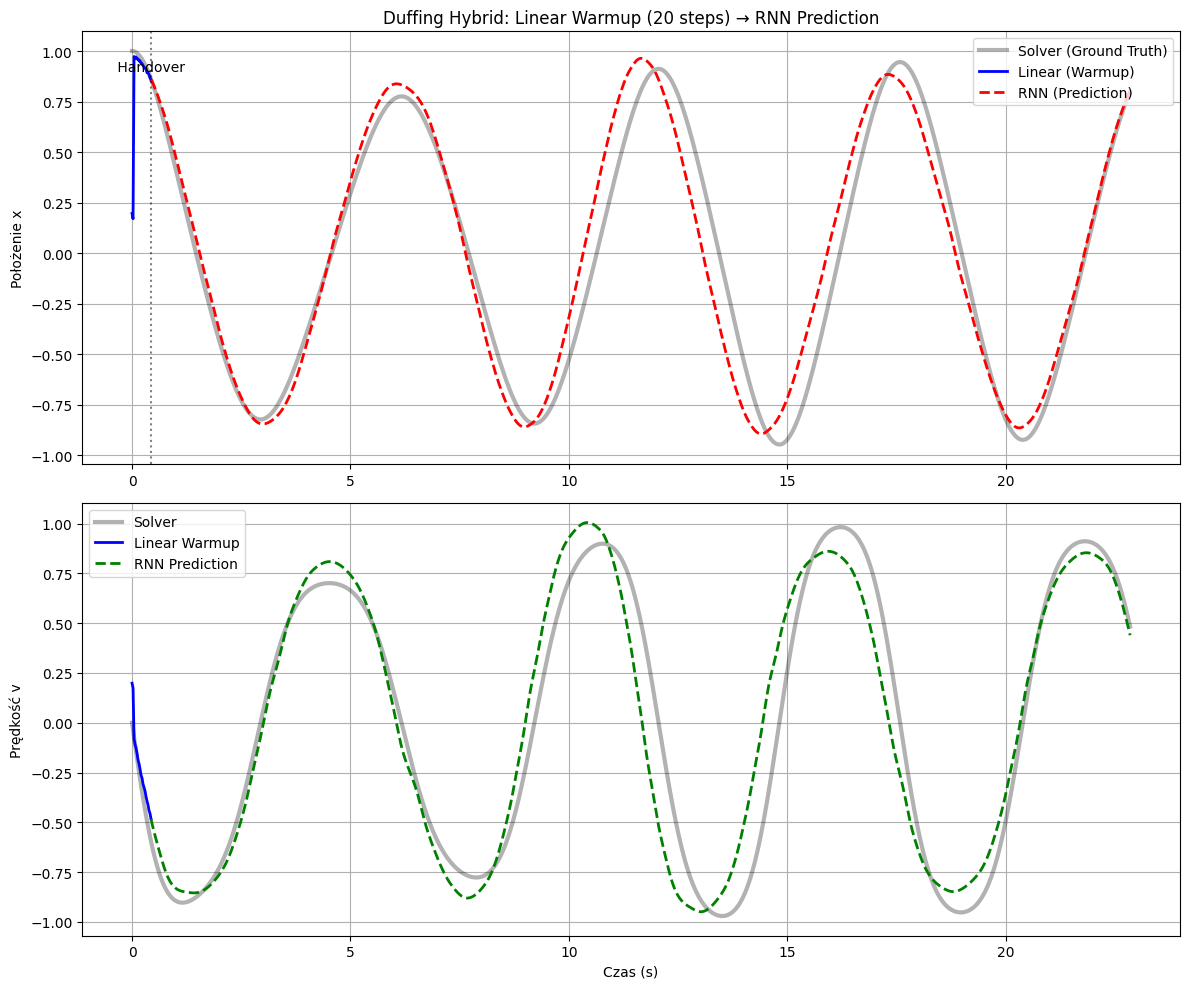


Błąd MSE (część Linear - warmup):
MSE x: 0.067146
MSE v: 0.009373

Błąd MSE (część RNN):
MSE x: 0.023921
MSE v: 0.036806


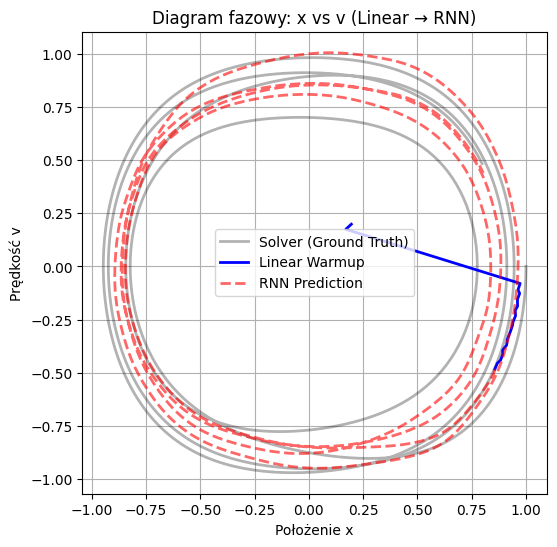

In [92]:
evaluate_linear_warmup(linear, rnn, X_max, 0.0, window_size, 0, t_end, n_dt)